In [1]:
#https://pub.towardsai.net/pragmatic-deep-learning-model-for-forex-forecasting-569aae6d4a1a
#https://archive.is/3SX0Q


import numpy as np
from datetime import datetime

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
batch_size = 7
window_size = int(63) # must be a multiple of batch_size
validation_size = 50 * batch_size # must be a multiple of batch_size
test_size = 50 * batch_size # must be a multiple of batch_size
ma_periods = 14 # Simple Moving Average periods length
ticker = 'gbpusd' # Your data file name without extention
start_date = '2014-01-01' # Ignore any data in the file prior to this date
seed = 42 # An arbitrary value to make sure your seed is the same
model_path = f'models/{ticker}-{batch_size}-{window_size}-{ma_periods}'
scaler_path = f'scalers/{ticker}-{batch_size}-{window_size}-{ma_periods}.bin'
full_time_series_path = f'data/{ticker}.csv'
train_time_series_path = f'data/{ticker}-train.csv'
validate_time_series_path = f'data/{ticker}-validate.csv'
test_time_series_path = f'data/{ticker}-test.csv'

In [4]:
symbol = 'GBPUSD=X'
df = yf.download(symbol, start="2014-01-01",end="2024-01-01")
df.index = pd.to_datetime(df.index)

start=pd.to_datetime('2021-01-01', format='%Y-%m-%d')
today_date = datetime.today().strftime('%Y-%m-%d')

[*********************100%%**********************]  1 of 1 completed


In [5]:
df["HLAvg"] = df['High'].add(df['Low']).div(2)
df.drop(columns=['Open','High','Low','Volume'],inplace=True)
# Simple Moving Average
df['MA'] = df['HLAvg'].rolling(window=ma_periods).mean()
# Log Returns
df['Returns'] = np.log(df['MA']/df['MA'].shift(1))
df.head(15)

,Close,Adj Close,HLAvg,MA,Returns
Date,,,,,
2014-01-01,1.656397,1.656397,1.656397,NaN,NaN
2014-01-02,1.658072,1.658072,1.651441,NaN,NaN
2014-01-03,1.644791,1.644791,1.643785,NaN,NaN
2014-01-06,1.641309,1.641309,1.638779,NaN,NaN
2014-01-07,1.641794,1.641794,1.640547,NaN,NaN
2014-01-08,1.640016,1.640016,1.642603,NaN,NaN
2014-01-09,1.644710,1.644710,1.646867,NaN,NaN
2014-01-10,1.647908,1.647908,1.644857,NaN,NaN
2014-01-13,1.649430,1.649430,1.643166,NaN,NaN


In [6]:
df.dropna(how='any', inplace=True)
df = df[df.shape[0] % batch_size:] #ensures number of rows in df is a multiple of batch_size
df

,Close,Adj Close,HLAvg,MA,Returns
Date,,,,,
2014-01-22,1.647528,1.647528,1.651648,1.642312,0.000009
2014-01-23,1.656205,1.656205,1.659608,1.643443,0.000688
2014-01-24,1.663478,1.663478,1.657545,1.644783,0.000815
2014-01-27,1.649049,1.649049,1.653469,1.645706,0.000561
2014-01-28,1.657495,1.657495,1.658205,1.646820,0.000677
...,...,...,...,...,...
2023-12-25,1.267700,1.267700,1.271183,1.263957,0.000536
2023-12-26,1.270487,1.270487,1.270247,1.264705,0.000591
2023-12-27,1.272718,1.272718,1.275083,1.265999,0.001023


In [7]:
df_train = df[:- validation_size - test_size]
df_validation = df[- validation_size - test_size - window_size:- test_size]
df_test = df[- test_size - window_size:]
print(f'df_train.shape {df_train.shape}, df_validation.shape {df_validation.shape}, df_test.shape {df_test.shape}')

df_train.shape (1890, 5), df_validation.shape (413, 5), df_test.shape (413, 5)


In [8]:
#df_train.to_csv(train_time_series_path)
#df_validation.to_csv(validate_time_series_path)
#df_test.to_csv(test_time_series_path)

In [9]:
df_validation

,Close,Adj Close,HLAvg,MA,Returns
Date,,,,,
2021-01-27,1.374155,1.374155,1.371111,1.363557,0.000647
2021-01-28,1.366942,1.366942,1.368214,1.364243,0.000503
2021-01-29,1.372501,1.372501,1.370498,1.365764,0.001114
2021-02-01,1.369769,1.369769,1.370745,1.366734,0.000710
2021-02-02,1.367877,1.367877,1.366156,1.366736,0.000002
...,...,...,...,...,...
2022-08-22,1.181810,1.181810,1.179056,1.207384,-0.002597
2022-08-23,1.176651,1.176651,1.179664,1.204828,-0.002119
2022-08-24,1.183278,1.183278,1.181205,1.202533,-0.001907


In [10]:
def get_train(values, window_size):
    X, y = [], []
    len_values = len(values)
    for i in range(window_size, len_values):
        X.append(values[i-window_size:i])
        y.append(values[i])
    X, y = np.asarray(X), np.asarray(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    print(f"X {X.shape}, y {y.shape}")
    return X, y

def get_val(values, window_size):
    X = []
    len_values = len(values)
    for i in range(window_size, len_values):
        X.append(values[i-window_size:i])
    X = np.asarray(X)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    y = values[-X.shape[0]:]
    print(f"X {X.shape}, y {y.shape}")
    return X, y

In [11]:
epochs = 200
np.random.seed(seed)
tf.random.set_seed(seed)

In [12]:
df_train

,Close,Adj Close,HLAvg,MA,Returns
Date,,,,,
2014-01-22,1.647528,1.647528,1.651648,1.642312,0.000009
2014-01-23,1.656205,1.656205,1.659608,1.643443,0.000688
2014-01-24,1.663478,1.663478,1.657545,1.644783,0.000815
2014-01-27,1.649049,1.649049,1.653469,1.645706,0.000561
2014-01-28,1.657495,1.657495,1.658205,1.646820,0.000677
...,...,...,...,...,...
2021-04-19,1.381845,1.381845,1.390116,1.379105,0.000804
2021-04-20,1.399384,1.399384,1.397272,1.380594,0.001079
2021-04-21,1.393884,1.393884,1.391795,1.381485,0.000646


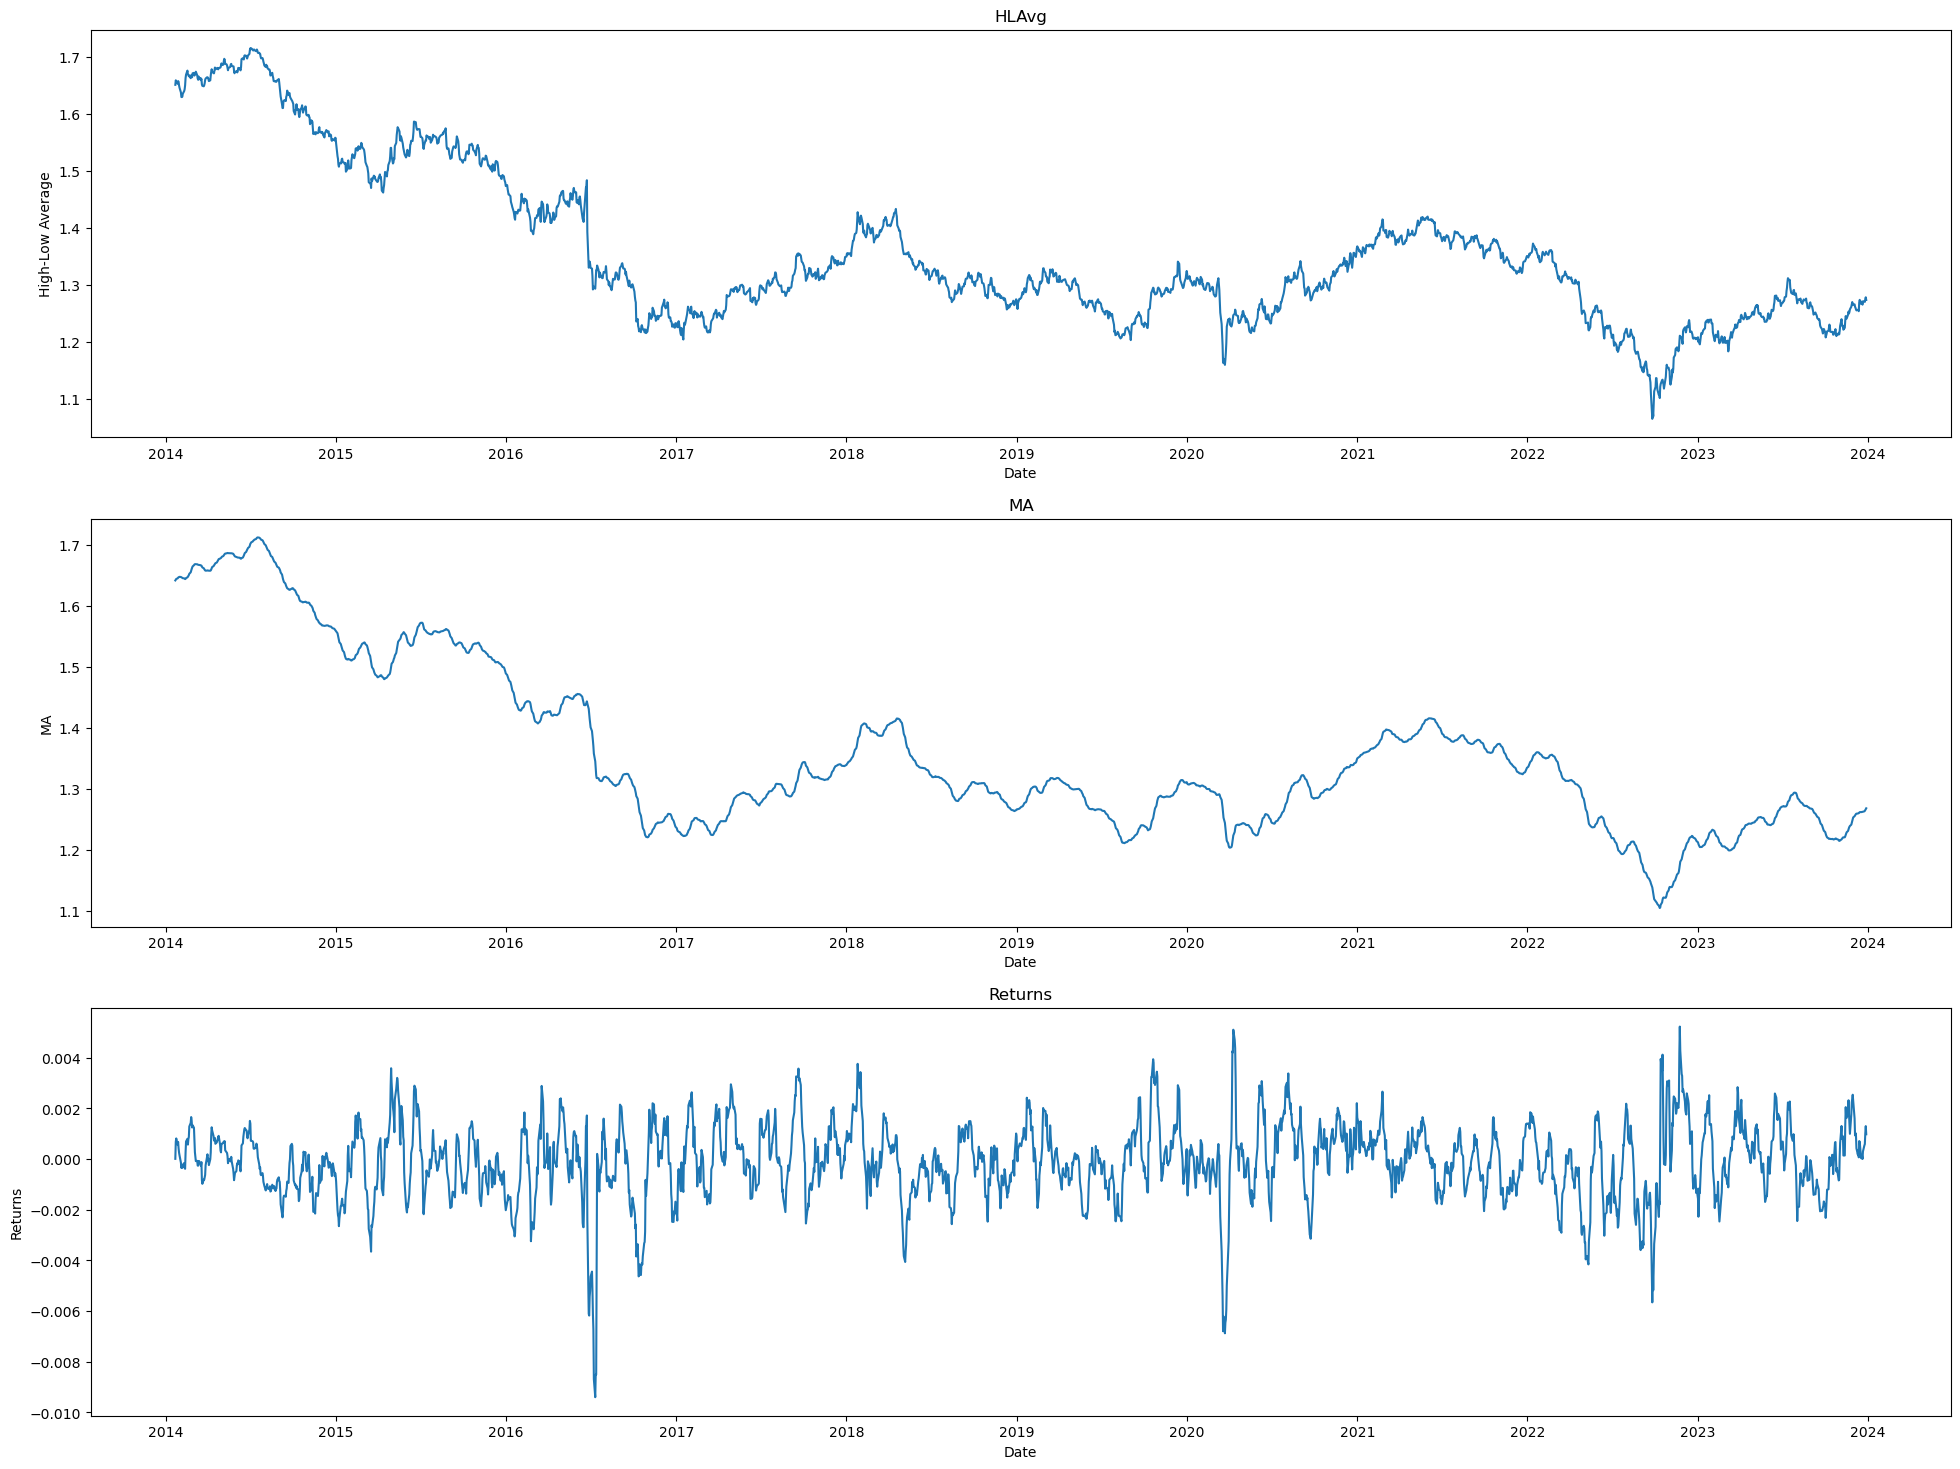

In [13]:
fig = plt.figure(figsize=(24, 18))
ax1, ax2, ax3 = fig.subplots(3)
ax1.set_title('HLAvg')
ax1.set(xlabel='Date', ylabel='High-Low Average')
ax1.plot(df['HLAvg'])
ax2.set_title('MA')
ax2.set(xlabel='Date', ylabel='MA')
ax2.plot(df['MA'])
ax3.set_title('Returns')
ax3.set(xlabel='Date', ylabel='Returns')
ax3.plot(df['Returns'])

In [14]:
scaler = MinMaxScaler()
train_values = scaler.fit_transform(df_train[['Returns']].values)

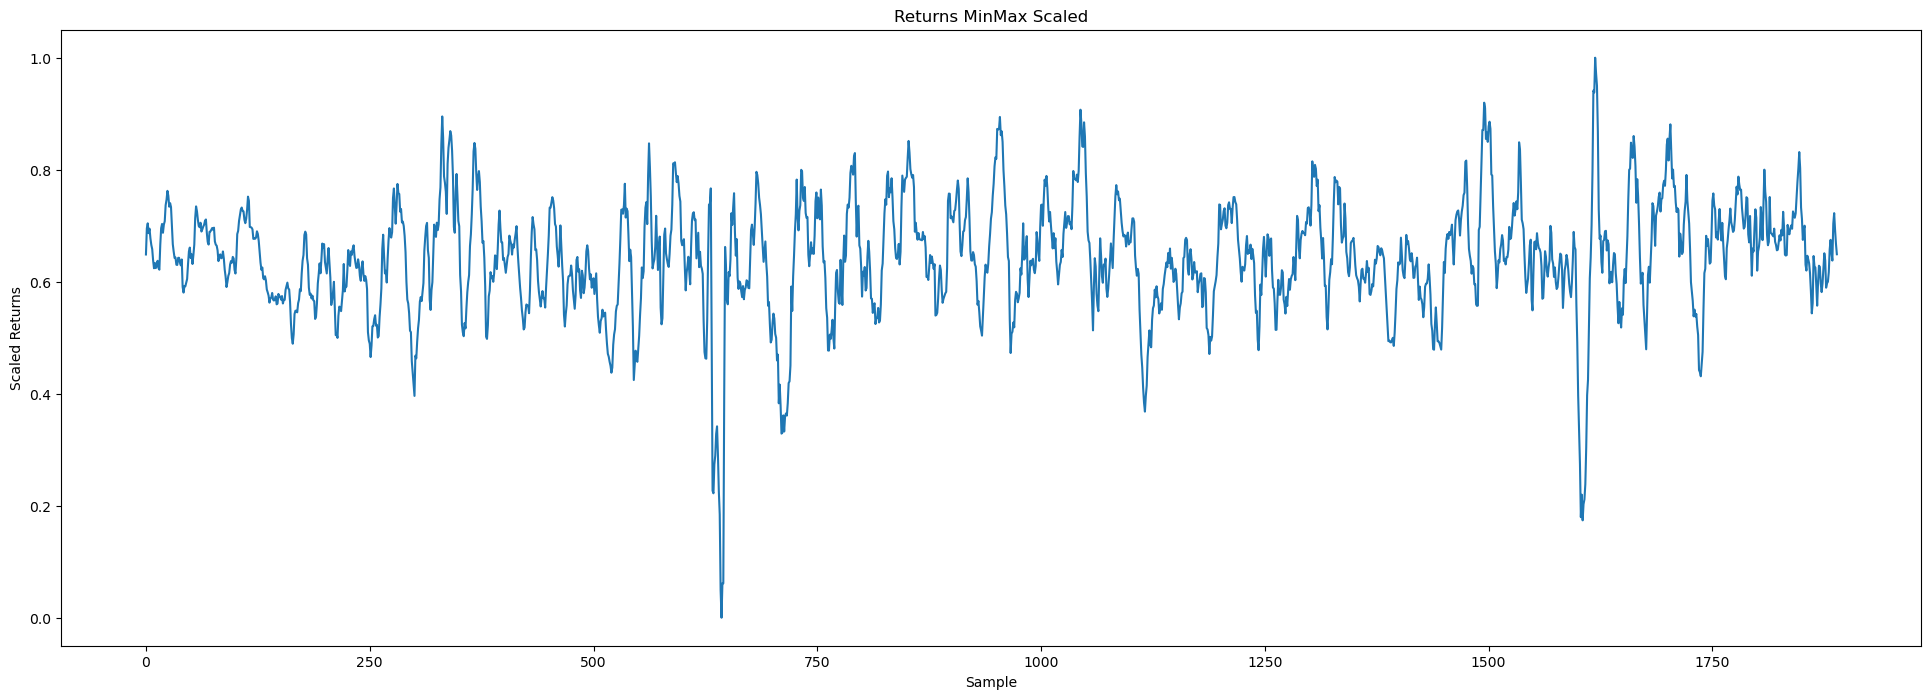

In [15]:
fig = plt.figure(figsize=(24, 8))
ax1 = fig.subplots(1)
ax1.set_title('Returns MinMax Scaled')
ax1.set(xlabel='Sample', ylabel='Scaled Returns')
ax1.plot(train_values)

In [16]:
X, y = get_train(train_values, window_size)

X (1827, 63, 1), y (1827, 1)


In [17]:
df_validation['Scaled'] = scaler.transform(df_validation[['Returns']].values)
X_val, y_val = get_val(df_validation['Scaled'].values, window_size)

X (350, 63, 1), y (350,)


/var/folders/9f/g6tpsc8n5qb861y9f7rpwlcm0000gn/T/ipykernel_10420/1283899271.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_validation['Scaled'] = scaler.transform(df_validation[['Returns']].values)


In [18]:
model = Sequential()
model.add(LSTM(76, input_shape=(X.shape[1], 1), return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(1))
optimizer = tf.keras.optimizers.Adam()
model.compile(loss="mse", optimizer=optimizer)

print(model.summary())

/Users/benny/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 76)             │        23,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 76)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            77 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,789 (92.93 KB)

 Trainable params: 23,789 (92.93 KB)

 Non-trainable params: 0 (0.00 B)

None


In [19]:
history = model.fit(X, y, validation_data=(X_val, y_val), epochs = epochs, batch_size = batch_size, shuffle=False, verbose = 2)

Epoch 1/200
261/261 - 2s - 8ms/step - loss: 0.0166 - val_loss: 0.0035
Epoch 2/200
261/261 - 1s - 6ms/step - loss: 0.0066 - val_loss: 0.0025
Epoch 3/200
261/261 - 1s - 6ms/step - loss: 0.0056 - val_loss: 0.0018
Epoch 4/200
261/261 - 1s - 6ms/step - loss: 0.0049 - val_loss: 0.0023
Epoch 5/200
261/261 - 1s - 6ms/step - loss: 0.0048 - val_loss: 0.0020
Epoch 6/200
261/261 - 1s - 6ms/step - loss: 0.0041 - val_loss: 0.0016
Epoch 7/200
261/261 - 2s - 6ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 8/200
261/261 - 2s - 6ms/step - loss: 0.0039 - val_loss: 0.0016
Epoch 9/200
261/261 - 1s - 6ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 10/200
261/261 - 2s - 6ms/step - loss: 0.0034 - val_loss: 0.0015
Epoch 11/200
261/261 - 2s - 6ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 12/200
261/261 - 1s - 6ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 13/200
261/261 - 1s - 6ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 14/200
261/261 - 2s - 6ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 15/200
26

261/261 - 1s - 6ms/step - loss: 0.0011 - val_loss: 7.3876e-04
Epoch 112/200
261/261 - 1s - 6ms/step - loss: 0.0011 - val_loss: 7.8460e-04
Epoch 113/200
261/261 - 1s - 6ms/step - loss: 0.0011 - val_loss: 7.2162e-04
Epoch 114/200
261/261 - 1s - 6ms/step - loss: 0.0011 - val_loss: 6.8637e-04
Epoch 115/200
261/261 - 1s - 6ms/step - loss: 0.0011 - val_loss: 7.3735e-04
Epoch 116/200
261/261 - 1s - 6ms/step - loss: 0.0012 - val_loss: 6.6262e-04
Epoch 117/200
261/261 - 1s - 6ms/step - loss: 0.0011 - val_loss: 6.9453e-04
Epoch 118/200
261/261 - 1s - 6ms/step - loss: 0.0011 - val_loss: 7.2004e-04
Epoch 119/200
261/261 - 1s - 6ms/step - loss: 0.0011 - val_loss: 7.0862e-04
Epoch 120/200
261/261 - 1s - 6ms/step - loss: 0.0011 - val_loss: 7.0005e-04
Epoch 121/200
261/261 - 1s - 6ms/step - loss: 0.0011 - val_loss: 7.8978e-04
Epoch 122/200
261/261 - 1s - 6ms/step - loss: 0.0011 - val_loss: 6.4557e-04
Epoch 123/200
261/261 - 1s - 6ms/step - loss: 0.0011 - val_loss: 7.9286e-04
Epoch 124/200
261/261 - 1s

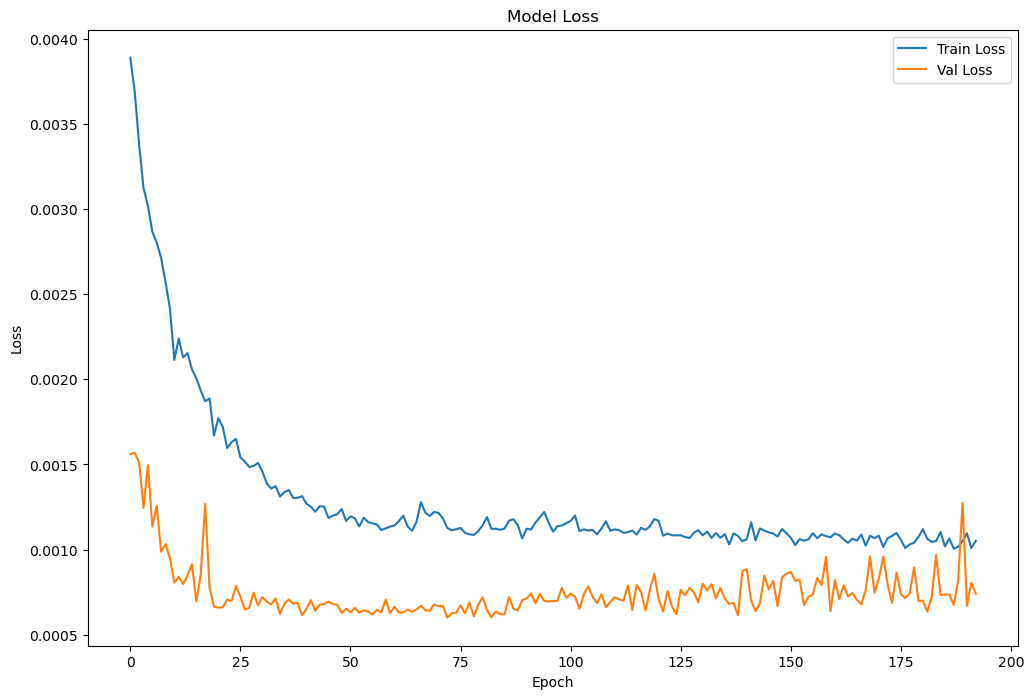

In [20]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.subplots(1)
ax1.set_title('Model Loss')
ax1.set(xlabel='Epoch', ylabel='Loss')
ax1.plot(history.history['loss'][7:], label='Train Loss')
ax1.plot(history.history['val_loss'][7:], label='Val Loss')
ax1.legend()

In [ ]:
#save_model(model, model_path)
#joblib.dump(scaler, scaler_path) 

In [21]:
df_test['Scaled'] = scaler.transform(df_test[['Returns']].values)

/var/folders/9f/g6tpsc8n5qb861y9f7rpwlcm0000gn/T/ipykernel_10420/4034711710.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Scaled'] = scaler.transform(df_test[['Returns']].values)


In [22]:
scaled = df_test['Scaled'].values
X = []
len_scaled = len(scaled)
for i in range(window_size, len_scaled):
    X.append(scaled[i-window_size:i])
X = np.asarray(X)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
y_true = scaled[-X.shape[0]:]
print(f"X {X.shape}, y_real {y_true.shape}")

X (350, 63, 1), y_real (350,)


In [23]:
mse = model.evaluate(X, y_true, verbose=1)
print("Mean Squared Error:", mse)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 
Mean Squared Error: 0.0013582909014075994


In [24]:
y_pred = model.predict(X)
y_pred.shape

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


(350, 1)

In [25]:
df_test['Pred_Scaled'] = np.pad(y_pred.reshape(y_pred.shape[0]), (window_size, 0), mode='constant', constant_values=np.nan)
df_test['Pred_Returns'] = scaler.inverse_transform(df_test[['Pred_Scaled']].values)
#df['Pred_MA'] = df["MA"].mul(1 + df['Pred_Returns'].shift(-1)).shift(1) # Arithmetic Returns
df_test['Pred_MA'] = df_test['MA'].mul(np.exp(df_test['Pred_Returns'].shift(-1))).shift(1) # Log Returns
df_test = df_test[window_size:]
df_test

/var/folders/9f/g6tpsc8n5qb861y9f7rpwlcm0000gn/T/ipykernel_10420/2632328974.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Pred_Scaled'] = np.pad(y_pred.reshape(y_pred.shape[0]), (window_size, 0), mode='constant', constant_values=np.nan)
/var/folders/9f/g6tpsc8n5qb861y9f7rpwlcm0000gn/T/ipykernel_10420/2632328974.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Pred_Returns'] = scaler.inverse_transform(df_test[['Pred_Scaled']].values)
/var/folders/9f/g6tpsc8n5qb861y9f7rpwlcm0000gn/T

,Close,Adj Close,HLAvg,MA,Returns,Scaled,Pred_Scaled,Pred_Returns,Pred_MA
Date,,,,,,,,,
2022-08-29,1.169454,1.169454,1.169609,1.195881,-0.002402,0.482395,0.557391,-0.001315,1.197183
2022-08-30,1.172251,1.172251,1.169055,1.192451,-0.002873,0.449953,0.491226,-0.002274,1.193165
2022-08-31,1.165977,1.165977,1.164740,1.188390,-0.003411,0.412831,0.461683,-0.002703,1.189232
2022-09-01,1.159851,1.159851,1.156017,1.184128,-0.003593,0.400334,0.429180,-0.003174,1.184624
2022-09-02,1.154894,1.154894,1.155996,1.180274,-0.003260,0.423278,0.429318,-0.003172,1.180378
...,...,...,...,...,...,...,...,...,...
2023-12-25,1.267700,1.267700,1.271183,1.263957,0.000536,0.684995,0.684910,0.000535,1.263956
2023-12-26,1.270487,1.270487,1.270247,1.264705,0.000591,0.688785,0.695850,0.000694,1.264834
2023-12-27,1.272718,1.272718,1.275083,1.265999,0.001023,0.718533,0.694533,0.000675,1.265558


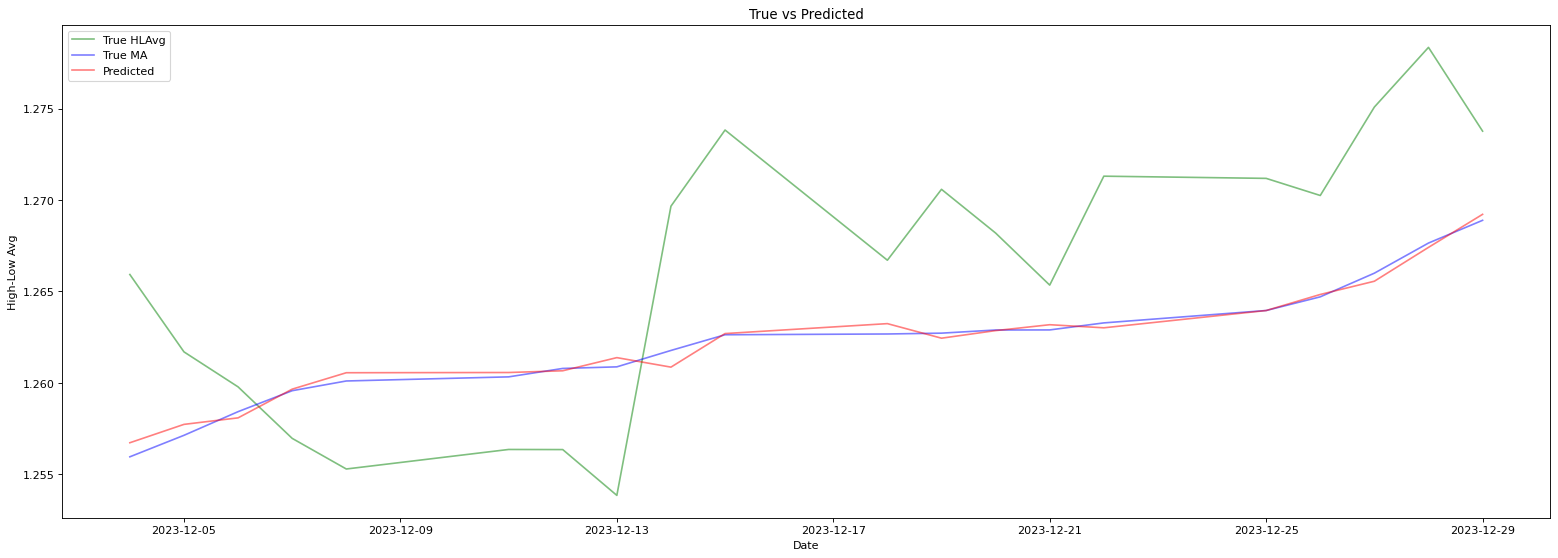

In [26]:
plt.figure(figsize=(24, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_test['HLAvg'][-20:], color = 'green', label = 'True HLAvg', alpha=0.5)
plt.plot(df_test['MA'][-20:], color = 'blue', label = 'True MA', alpha=0.5)
plt.plot(df_test['Pred_MA'][-20:], color = 'red', label = 'Predicted', alpha=0.5)
plt.title('True vs Predicted')
plt.xlabel('Date')
plt.ylabel('High-Low Avg')
plt.legend()
plt.show()

In [29]:
pred_interval = 5 # Predict every n minutes
pred_size = 21 # Prediction length into the future

df_test['Scaled'] = scaler.transform(df_test[['Returns']].values)
scaled = df_test['Scaled'].values

# Create empty column to store the multi predictions
df_test["Pred_Close_From"] =  np.nan
df_test["Pred_Close_To"] = np.nan

# Cache the column indices 
pred_close_from_col_index = df_test.columns.get_loc('Pred_Close_From')
pred_close_to_col_index = df_test.columns.get_loc('Pred_Close_To')

ma_col_index = df_test.columns.get_loc('MA')
predictions_for_plot = []
df_test_len = df_test.shape[0]
for i in range(window_size, df_test_len - pred_size, pred_interval):
    X = [scaled[i-window_size:i]]
    y = []
    y_ma = df_test.iloc[i - 1, ma_col_index]
    for _ in range(pred_size):
        X = np.asarray(X)
        X = np.reshape(X, (1, window_size, 1))
        y_pred_scaled = model.predict(X)
        y_return = scaler.inverse_transform(y_pred_scaled)
        #y_ma = y_ma * (1 + y_return) # Arithmetic Returns
        y_ma = y_ma * np.exp(y_return) # Log Returns
        y.append(float(y_ma))
        # Remove first item in the list
        X = np.delete(X, 0)
        # Add the new prediction to the end
        X = np.append(X, y_pred_scaled)

    df_test.iloc[i, pred_close_from_col_index] = y[0]
    df_test.iloc[i, pred_close_to_col_index] = y[-1]
    y_padded = np.pad(y, (i, df_test_len - pred_size - i), mode='constant', constant_values=np.nan)
    df_test_plot = pd.Series(data=y_padded,index=df_test.index)

    predictions_for_plot.append(df_test_plot)

df_test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/ste

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/st

,Close,Adj Close,HLAvg,MA,Returns,Scaled,Pred_Scaled,Pred_Returns,Pred_MA,Pred_Close_From,Pred_Close_To
Date,,,,,,,,,,,
2022-08-29,1.169454,1.169454,1.169609,1.195881,-0.002402,0.482395,0.557391,-0.001315,1.197183,NaN,NaN
2022-08-30,1.172251,1.172251,1.169055,1.192451,-0.002873,0.449953,0.491226,-0.002274,1.193165,NaN,NaN
2022-08-31,1.165977,1.165977,1.164740,1.188390,-0.003411,0.412831,0.461683,-0.002703,1.189232,NaN,NaN
2022-09-01,1.159851,1.159851,1.156017,1.184128,-0.003593,0.400334,0.429180,-0.003174,1.184624,NaN,NaN
2022-09-02,1.154894,1.154894,1.155996,1.180274,-0.003260,0.423278,0.429318,-0.003172,1.180378,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,1.267700,1.267700,1.271183,1.263957,0.000536,0.684995,0.684910,0.000535,1.263956,NaN,NaN
2023-12-26,1.270487,1.270487,1.270247,1.264705,0.000591,0.688785,0.695850,0.000694,1.264834,NaN,NaN
2023-12-27,1.272718,1.272718,1.275083,1.265999,0.001023,0.718533,0.694533,0.000675,1.265558,NaN,NaN


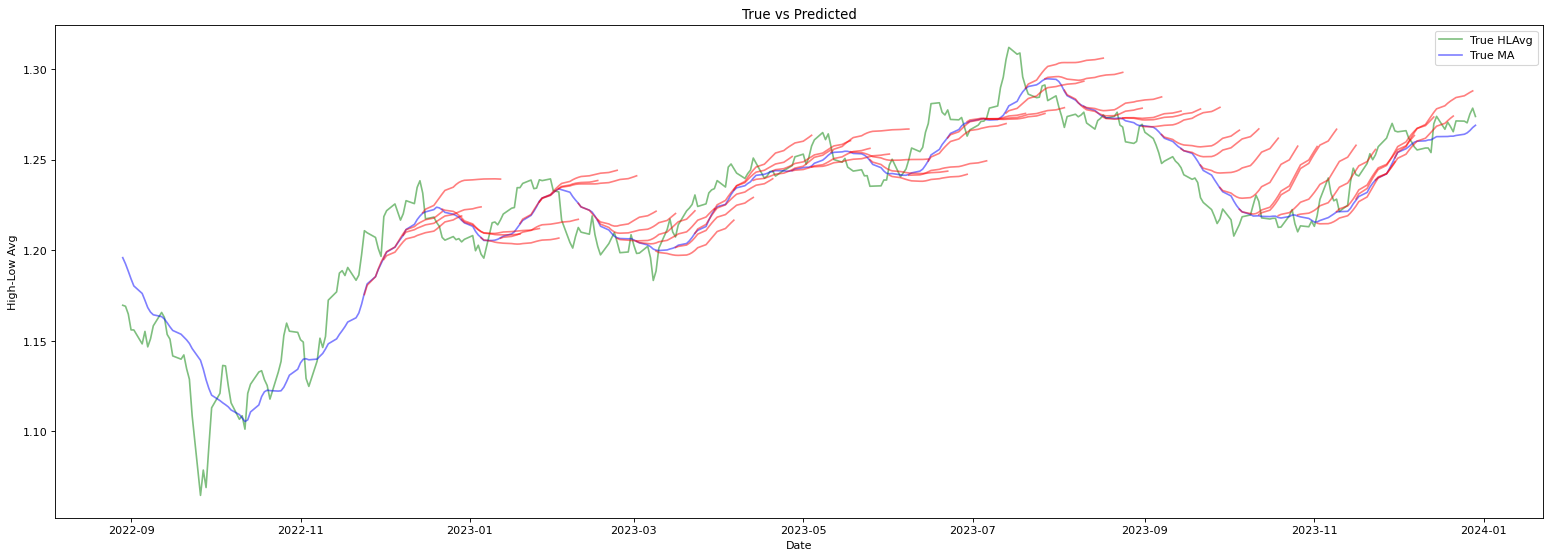

In [30]:
plt.figure(figsize=(24, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_test['HLAvg'], color = 'green', label = 'True HLAvg', alpha=0.5)
plt.plot(df_test['MA'], color = 'blue', label = 'True MA', alpha=0.5)
for i in range(len(predictions_for_plot)):
    plt.plot(predictions_for_plot[i], color = 'red', alpha=0.5)
plt.title('True vs Predicted')
plt.xlabel('Date')
plt.ylabel('High-Low Avg')
plt.legend()
plt.show()